In [49]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical, CustomObjectScope
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import he_uniform

import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


In [50]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train[0].shape, "\n")
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape((-1, img_rows, img_cols, channels))
X_test = X_test.reshape((-1, img_rows, img_cols, channels))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

(28, 28) 



In [51]:
print(X_test[2].ravel().shape)

(784,)


In [52]:
(X_train_C, y_train_C), (X_test_C, y_test_C) = cifar10.load_data()

img_cols_C, img_rows_C, channels_C = 32, 32, 3
num_classes_C = 10

test_images_1d = X_test.reshape((10000, 28 * 28))
test_images_1d = test_images_1d.astype('float32') / 255
X_train_C = X_train_C / 255
X_test_C = X_test_C / 255

X_train_C = X_train_C.reshape((-1, img_rows_C, img_cols_C, channels_C))
X_test_C = X_test_C.reshape((-1, img_rows_C, img_cols_C, channels_C))

y_train_C = to_categorical(y_train_C, num_classes_C)
y_test_C = to_categorical(y_test_C, num_classes_C)

labels_C = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [53]:
print(X_test_C[2].ravel().shape)


(3072,)


In [54]:
jfile = open("../CNN_model_cifar.json", "r")
loaded_json1 = jfile.read()
jfile.close()
with CustomObjectScope({'HeUniform': he_uniform()}):
    loaded_model1 = model_from_json(loaded_json1)
loaded_model1.load_weights("../CNN_model_cifar.h5")
loaded_model1.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=['accuracy'])

loaded_model1.summary()

Model: "CNN_model_cifar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)    

In [55]:

jfile = open("../CNN_model_mnist.json", "r")
loaded_json = jfile.read()
jfile.close()
loaded_model = model_from_json(loaded_json)
loaded_model.load_weights("../CNN_model_mnist.h5")
loaded_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

jfile = open("../CNN_model_mnist_adversarial.json", "r")
loaded_json_adv = jfile.read()
jfile.close()
loaded_model_adv = model_from_json(loaded_json_adv)
loaded_model_adv.load_weights("../CNN_model_mnist_adversarial.h5")
loaded_model_adv.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [56]:
class JSMA(object):

    def __init__(self, model, X, Y, channels, clip_min=0.0, clip_max=1.0):

        self.model = model

        self.eps = 0
        self.clip_min = clip_min
        self.clip_max = clip_max

        self.img_rows = X
        self.img_cols = Y
        self.channels = channels

    def get_logits(self):
        self.model.layers[-1].activation = None

    def get_probs(self, logits):
        return tf.nn.softmax(logits)

    def compute_jacobian_matrix(self, image, target, y_inidx, y_tidx):
        # compute jacobian of model prediction with respect to input

        self.get_logits()

        logits = self.model(image)

        logits = np.array(tf.reshape(logits, (-1, )))
        logidx, logidx_target = logits[y_inidx], logits[y_tidx]

        jacobian, jacobian_target = np.gradient(image.ravel(), logidx),\
                              np.gradient(target.ravel(), logidx_target)

        return tf.cast(jacobian.reshape(1, self.img_cols, self.img_rows, self.channels), tf.float32), \
               tf.cast(jacobian_target.reshape(1, self.img_cols, self.img_rows, self.channels), tf.float32)


    def compute_saliency_map(self, input_image, dF_tX, dF_jX):
        # compute saliency map with respect to jacobian
        c1, c2 = tf.logical_or(self.eps < 0, input_image < self.clip_max), \
                 tf.logical_or(self.eps > 0, input_image > self.clip_min)

        sal1 = dF_tX >= 0
        sal2 = dF_jX <= 0

        shape = input_image.ravel().shape[0]

        condition = tf.cast(tf.reduce_all([c1, c2, sal1, sal2], axis=0), dtype=tf.float32)
        score_sm = condition * (dF_tX * tf.abs(dF_jX))

        score_sm = tf.reshape(score_sm, shape=[1, shape])
        return score_sm

    def adversarial_patternJSMA(self, input_image, target_image, y_inidx, y_tidx,  max_iter):
        # generate adversarial perturbations
        perturbations = []

        jacobian_input, jacobian_target= self.compute_jacobian_matrix(input_image, target_image, y_inidx, y_tidx)
        jacobian_adv = jacobian_input - jacobian_target

        saliency_score = self.compute_saliency_map(input_image, jacobian_target, jacobian_adv)
        shape = input_image.ravel().shape[0]
        update_map = np.ones((1, shape), dtype=np.float32)

        i = 0
        while i < max_iter:
            # self.eps = np.random.uniform(0.01, 2.5)
            self.eps = 1.0
            idx = tf.argmax(saliency_score, axis=1)
            update_map[:, int(idx)] = 0.0
            update_map = tf.constant(update_map, dtype=tf.float32)
            saliency_score = saliency_score * update_map

            update_map = np.array(update_map, dtype=np.float32)
            perturbation = tf.one_hot(idx, shape, on_value=self.eps, off_value=0.0)
            perturbation = tf.reshape(perturbation, shape=tf.shape(input_image))

            perturbations.append(perturbation)
            i+=1

        pert_sum = tf.zeros((1, self.img_cols, self.img_rows, self.channels), dtype=tf.float32)
        for pert in perturbations:
            pert_sum += pert

        adversarial_image = tf.clip_by_value(tf.stop_gradient(input_image + pert_sum), self.clip_min, self.clip_max)


        return np.array(adversarial_image), np.array(pert_sum)


In [57]:
jsma = JSMA(loaded_model, img_rows, img_cols, channels)


In [164]:
image = X_test[72].reshape((1, img_rows, img_cols, channels))

target = X_test[54].reshape((1, img_rows, img_cols, channels))
adv, pert = jsma.adversarial_patternJSMA(image, target, np.argmax(y_test[72]), np.argmax(y_test[54]),
                                         max_iter=90)

image1 = X_test[35].reshape((1, img_rows, img_cols, channels))

target1 = X_test[58].reshape((1, img_rows, img_cols, channels))
adv1, pert1 = jsma.adversarial_patternJSMA(image1, target1, np.argmax(y_test[122]), np.argmax(y_test[58]),
                                           max_iter=130)
# 122

In [59]:
print("image №1: %s" % labels[np.argmax(y_test[72])])
print("image №2: %s" % labels[np.argmax(y_test[122])], "\n")

print("target №1: %s" % labels[np.argmax(y_test[54])])
print("target №2: %s" % labels[np.argmax(y_test[58])])

image №1: two
image №2: seven 

target №1: six
target №2: nine


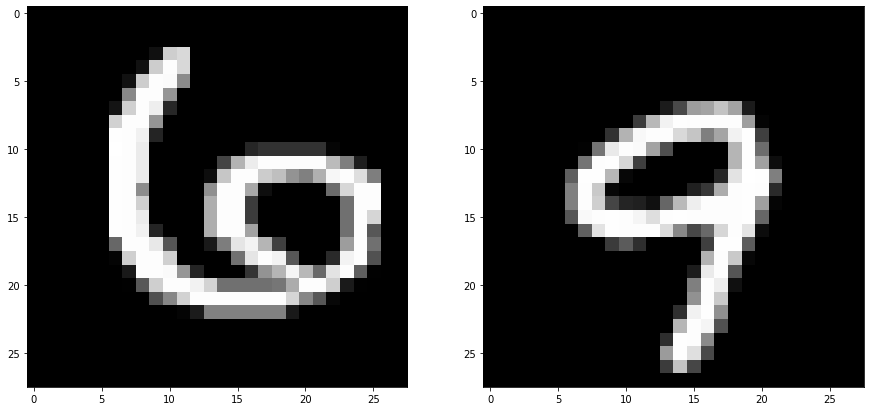

In [156]:
plt.figure(figsize=(15, 15))
# 21
plt.subplot(121)
plt.imshow(X_test[54], cmap="gray")

plt.subplot(122)
plt.imshow(X_test[58], cmap="gray")

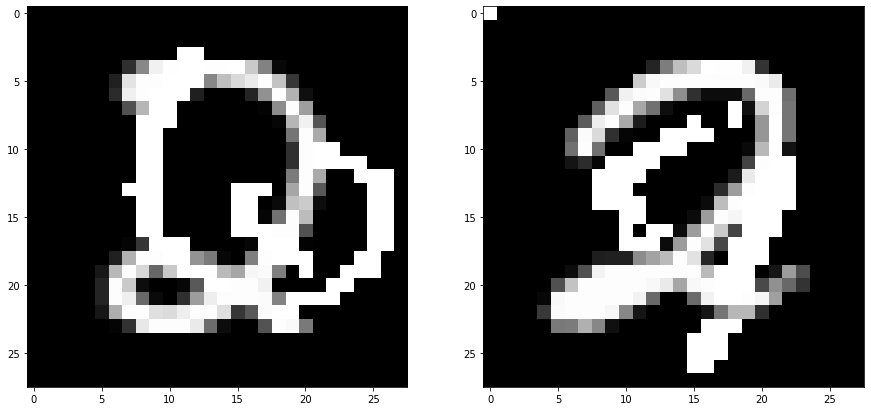

In [165]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(adv.reshape(28, 28), cmap="gray")

plt.subplot(122)
plt.imshow(adv1.reshape(28, 28), cmap="gray")

In [166]:
print("{}".format([np.around(num, 3) for num in tf.nn.softmax(loaded_model.predict(tf.reshape(adv,
                            shape=(1, img_cols, img_rows, channels))))]))


[array([0.241, 0.   , 0.191, 0.   , 0.   , 0.   , 0.56 , 0.   , 0.007,
       0.   ], dtype=float32)]


In [167]:
print("Prediction of original model on adversarial image: %d" % loaded_model.predict(tf.reshape(adv, shape=(1, img_cols, img_rows, channels))).argmax())
print("Prediction of adversarial model on adversarial model: %d" % loaded_model_adv.predict(tf.reshape(adv, shape=(1, img_cols, img_rows, channels))).argmax())

Prediction of original model on adversarial image: 6
Prediction of adversarial model on adversarial model: 0


In [168]:
print("Prediction of original model on adversarial image: %d" % loaded_model.predict(tf.reshape(adv1, shape=(1, img_cols, img_rows, channels))).argmax())
print("Prediction of adversarial model on adversarial model: %d" % loaded_model_adv.predict(tf.reshape(adv1, shape=(1, img_cols, img_rows, channels))).argmax())

Prediction of original model on adversarial image: 9
Prediction of adversarial model on adversarial model: 8


In [64]:
jsma1 = JSMA(loaded_model1, img_rows_C, img_cols_C, channels_C)

In [65]:
image_С = X_test_C[91].reshape((1, img_rows_C, img_cols_C, channels_C))

target_С = X_test_C[65].reshape((1, img_rows_C, img_cols_C, channels_C))
adv_C, pert_С = jsma1.adversarial_patternJSMA(image_С, target_С, np.argmax(y_test_C[91]),
                                             np.argmax(y_test_C[65]), max_iter=300)

image_С1 = X_test_C[126].reshape((1, img_rows_C, img_cols_C, channels_C))

target_С1 = X_test_C[47].reshape((1, img_rows_C, img_cols_C, channels_C))
adv_C1, pert_С1 = jsma1.adversarial_patternJSMA(image_С1, target_С1, np.argmax(y_test_C[126]),
                                             np.argmax(y_test_C[47]), max_iter=390)

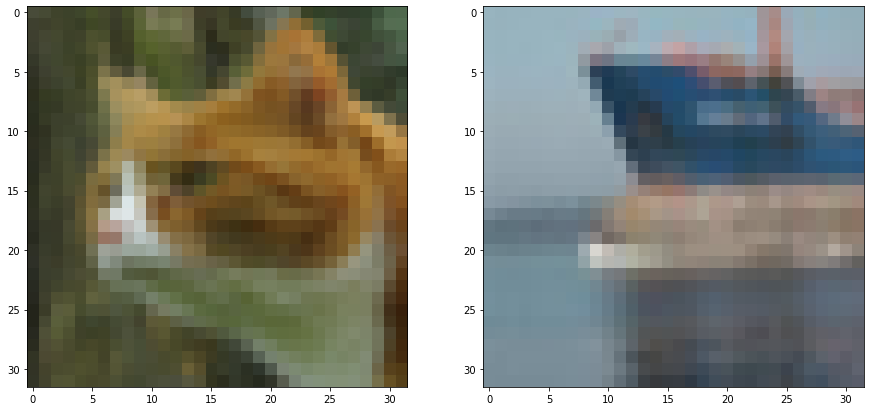

In [66]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(X_test_C[91], cmap="gray")

plt.subplot(122)
plt.imshow(X_test_C[126], cmap="gray")

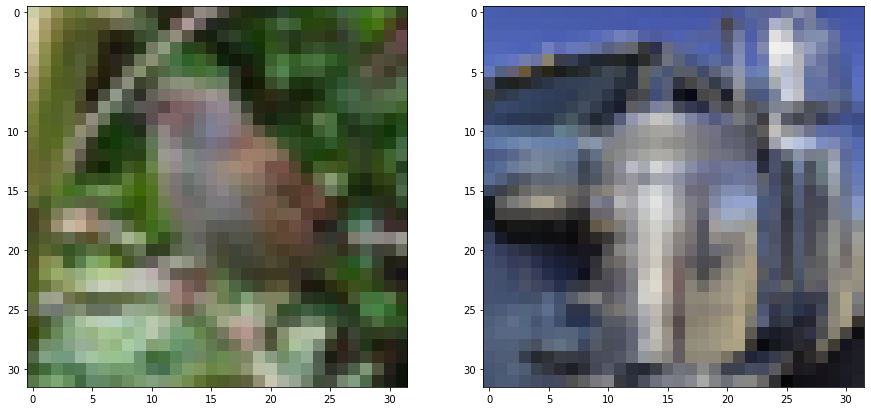

In [67]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(X_test_C[65])

plt.subplot(122)
plt.imshow(X_test_C[47])

In [68]:
print("image №1: %s" % labels_C[np.argmax(y_test_C[91])])
print("image №2: %s" % labels_C[np.argmax(y_test_C[126])], "\n")

print("target №1: %s" % labels_C[np.argmax(y_test_C[65])])
print("target №2: %s" % labels_C[np.argmax(y_test_C[47])])

image №1: cat
image №2: ship 

target №1: bird
target №2: truck


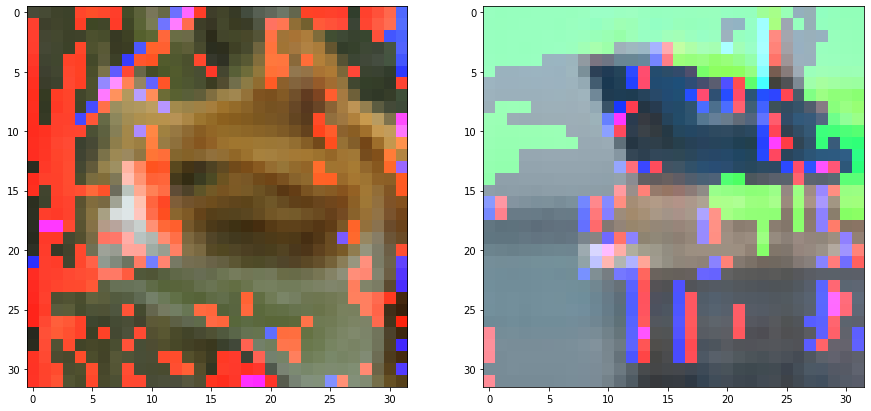

In [69]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(adv_C.reshape(32, 32, 3))

plt.subplot(122)
plt.imshow(adv_C1.reshape(32, 32, 3))


In [70]:
print(labels_C[loaded_model1.predict(tf.reshape(adv_C, shape=(1, img_cols_C, img_rows_C, channels_C))).argmax()])
print(labels_C[loaded_model1.predict(tf.reshape(adv_C1, shape=(1, img_cols_C, img_rows_C, channels_C))).argmax()])


bird
truck


In [71]:
image = X_test[75].reshape((1, img_rows, img_cols, channels))

target = X_test[54].reshape((1, img_rows, img_cols, channels))
adv, pert = jsma.adversarial_patternJSMA(image, target, np.argmax(y_test[72]), np.argmax(y_test[54]),
                                         max_iter=40)

image1 = X_test[129].reshape((1, img_rows, img_cols, channels))

target1 = X_test[58].reshape((1, img_rows, img_cols, channels))
adv1, pert1 = jsma.adversarial_patternJSMA(image1, target1, np.argmax(y_test[122]), np.argmax(y_test[58]),
                                           max_iter=40)

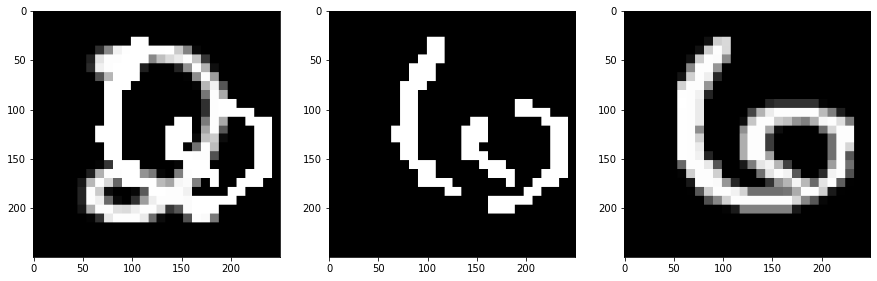

In [128]:
import cv2

plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(cv2.resize(adv.reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST), cmap="gray")

plt.subplot(132)
plt.imshow(cv2.resize(pert.reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST), cmap="gray")

plt.subplot(133)
plt.imshow(cv2.resize(X_test[54].reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST), cmap="gray")

# plt.imsave("default_image.png", cv2.resize(X_test[75].reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST))
# plt.imsave("adversarial1.png", cv2.resize(adv.reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST))
plt.imsave("target.png", cv2.resize(X_test[54].reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST))
